# Modeling

## Set up and configure connection to SDK

In [12]:
import datarobot as dr #needs 2.25 or later
import pickle
import graphviz
from datetime import datetime

In [13]:
dr.Client(config_path = '/Volumes/GoogleDrive/My Drive/Configurations/drconfig.yaml')

## Load project

In [14]:
projectPickle = open('project.pickle','rb')
project = pickle.load(projectPickle)
projectPickle.close()

## Inspect the features

DataRobot automatically aggregated the time-stamped information from the secondary dataset and created features for the entries in the primary datasets.

Let's investigate them. You can also download them and the SQL code that produced them. See notes at the end.

In [15]:
project.get_featurelists()

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Raw Features (Pre Feature Engineering)),
 Featurelist(Univariate Selections)]

In [16]:
project.get_features()
for (i, feature) in enumerate(project.get_features()):
    print(i, feature)

0 Feature(flow_id)
1 Feature(lot_id)
2 Feature(product_id)
3 Feature(qc_fail)
4 Feature(timestamp)
5 Feature(timestamp (Day of Week))
6 Feature(timestamp (Hour of Day))
7 Feature(biSecondlyReadings[flag_a3] (5 minutes entropy))
8 Feature(biSecondlyReadings[flag_b2] (1 hour median))
9 Feature(biSecondlyReadings[flag_c1] (1 hour unique count))
10 Feature(biSecondlyReadings[flag_c1] (1 minute avg))
11 Feature(biSecondlyReadings[flag_c1] (1 minute counts))
12 Feature(biSecondlyReadings[flag_c1] (1 minute std))
13 Feature(biSecondlyReadings[process] (5 minutes entropy))
14 Feature(biSecondlyReadings[sensor_q2] (1 hour sum))
15 Feature(biSecondlyReadings[sensor_t6] (3 hours max))
16 Feature(biSecondlyReadings[sensor_t7] (1 hour min))
17 Feature(biSecondlyReadings[sensor_t8] (5 minutes max))
18 Feature(biSecondlyReadings[sensor_t9] (1 hour std))
19 Feature(biSecondlyReadings[sensor_t9] (5 minutes min))
20 Feature(biSecondlyReadings[flag_a1] (3 hours median))
21 Feature(biSecondlyReadings[flag

### Closer look at a single feature

In [17]:
f = project.get_features()[24]

Basic information:

In [18]:
print('name: %s'%f.name)
print('importance: %f'%f.importance)
print('target leakage: %r'%f.target_leakage)

name: biSecondlyReadings[flag_a4] (1 minute most frequent)
importance: 0.047412
target leakage: 'FALSE'


Lineage:

In [19]:
dr.models.FeatureLineage.get(f.project_id,f.feature_lineage_id).steps

[{'id': 0,
  'step_type': 'generatedColumn',
  'parents': [],
  'name': 'biSecondlyReadings[flag_a4] (1 minute most frequent)',
  'data_type': 'Numeric'},
 {'id': 1,
  'step_type': 'action',
  'parents': [0],
  'name': 'Mode (most frequent category)',
  'description': 'Finds the mode (most frequently observed category) of a categorical feature.',
  'is_time_aware': False,
  'group_by': []},
 {'id': 2,
  'step_type': 'join',
  'parents': [1],
  'is_time_aware': False,
  'join_info': {'join_type': 'left',
   'left_table': {'datasteps': [4], 'columns': ['product_id']},
   'right_table': {'datasteps': [5], 'columns': ['product_id']}}},
 {'id': 3,
  'step_type': 'action',
  'parents': [2],
  'name': 'Value counts',
  'description': 'Counts values of a given type within the feature derivation window.\n        The whole dataset is in use when time aware feature engineering is disabled.',
  'is_time_aware': True,
  'group_by': ['product_id'],
  'time_info': {'latest': {'duration': 0, 'time_uni

Extract data for plotting, e.g. histogram

In [10]:
f.get_histogram().plot

[{'label': '0.0', 'count': 1389, 'target': 0.1303095752339813},
 {'label': '1.0', 'count': 192, 'target': 0.390625}]

## Inspect the blueprints

In manual mode DataRobot will populate a list of recommended models, but will not insert any of them into the queue.

This lets you select which models to execute before starting the modeling process.

### List all blueprints selected automatically

In [20]:
blueprints = project.get_blueprints()
for (i, blueprint) in enumerate(blueprints):
    print(i, blueprint)

0 Blueprint(Keras Deep Residual Neural Network Classifier using Training Schedule (3 Layers: 512, 64, 64 Units))
1 Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_d] (1 minute counts))
2 Blueprint(Majority Class Classifier)
3 Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a5] (1 minute counts))
4 Blueprint(Eureqa Generalized Additive Model Classifier (40 Generations))
5 Blueprint(Gaussian Process Classifier with Radial Basis Function Kernel)
6 Blueprint(Gradient Boosted Trees Classifier)
7 Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_c1] (1 hour counts))
8 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance))
9 Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a1] (1 minute counts))
10 Blueprint(RandomForest Classifier (Entropy) (Shallow) )
11 Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a4] (1 minute counts))
12 B

### Closer look at a blueprint

In [21]:
bp = blueprints[0]

In [22]:
print('model type: {}'.format(bp.model_type))
print('processes:')
for (i, p) in enumerate(bp.processes):
    print('{} - {}'.format(i, p))

model type: Keras Deep Residual Neural Network Classifier using Training Schedule (3 Layers: 512, 64, 64 Units)
processes:
0 - One-Hot Encoding
1 - Summarized Categorical to Sparse Matrix
2 - Numeric Data Cleansing
3 - Smooth Ridit Transform
4 - Standardize
5 - Matrix of word-grams occurrences
6 - Keras Deep Residual Neural Network Classifier using Training Schedule (3 Layers: 512, 64, 64 Units)


Graphical representation:

BlueprintChart(15 nodes, 18 edges)


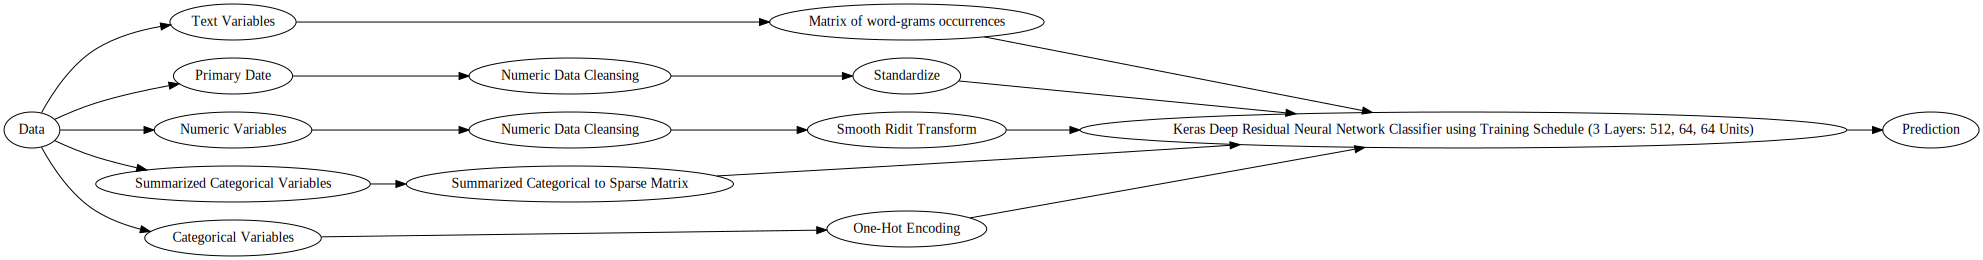

In [23]:
bpChart = bp.get_chart()
print(bpChart)
src = graphviz.Source(bpChart.to_graphviz())
src

Documentation:

In [24]:
bp.get_documents()

[BlueprintTaskDocument(One-Hot Encoding Documentation — DataRobot Model Documentation),
 BlueprintTaskDocument(Summarized Categorical to Sparse Matrix Documentation — DataRobot Model Documentation),
 BlueprintTaskDocument(Smooth Ridit Transform Documentation — DataRobot Model Documentation),
 BlueprintTaskDocument(Numeric Data Cleansing Documentation — DataRobot Model Documentation),
 BlueprintTaskDocument(Standardize Documentation — DataRobot Model Documentation),
 BlueprintTaskDocument(Matrix of word-grams occurrences Documentation — DataRobot Model Documentation),
 BlueprintTaskDocument(Keras Neural Network Classifier Documentation — DataRobot Model Documentation)]

In [25]:
bpDoc = bp.get_documents()[5]
print('references for {}:',format(bpDoc.task))
for (i, link) in enumerate(bpDoc.links):
    print('{} - {}: {}'.format(i, link['name'], link['url']))

references for {}: Document-Term Matrix
0 - sklearn text feature extraction user guide: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
1 - Document-term matrix wikipedia: https://en.wikipedia.org/wiki/Document-term_matrix
2 - tf-idf wikipedia: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
3 - N-gram wikipedia: https://en.wikipedia.org/wiki/N-gram
4 - NLTK stemmers (snowball, lancaster, porter, wordnet): http://www.nltk.org/api/nltk.stem.html


In [26]:
bpDoc.links[0]['name']

'sklearn text feature extraction user guide'

## Manually models from this list to train

In [27]:
bp_to_train = list()
for bp_id in [0, 6, 17, 25, 26, 35]:
    bp_to_train.append(blueprints[bp_id])
    print('Added {}'.format(bp_to_train[-1]))

Added Blueprint(Keras Deep Residual Neural Network Classifier using Training Schedule (3 Layers: 512, 64, 64 Units))
Added Blueprint(Gradient Boosted Trees Classifier)
Added Blueprint(Naive Bayes combiner classifier)
Added Blueprint(eXtreme Gradient Boosted Trees Classifier)
Added Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a1] (1 hour counts))
Added Blueprint(Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a5] (5 minutes counts))


In [19]:
bpDoc.links[0]['name']

'sklearn text feature extraction user guide'

You can also manually create / modify a blueprint, and add it:
- https://docs.datarobot.com/en/docs/release/public-preview/automl-preview/cml/index.html#composable-ml
- https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.26.1/autodoc/api_reference.html#blueprint

## Model

Don't forget to scale up workers for parallel processing

In [28]:
project.set_worker_count(20)

Project(Fault prediction from sensor data Orsted - Project set up)

Kick off training

In [29]:
for bp in bp_to_train:
    project.train(bp)

Show model jobs. Notice that the blueprints are kicked off multiple times, for the different aggregations:

In [30]:
project.get_all_jobs()

[Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=inprogress),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 Job(model, status=queue),
 J

## List trained models

In [5]:
modelsTrained = project.get_models()
modelsTrained

[Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Gradient Boosted Trees Classifier'),
 Model('Keras Deep Residual Neural Network Classifier using Training Schedule (3 Layers: 512, 64, 64 Units)'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[process] (3 hours counts)'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a3] (3 hours counts)'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a3] (1 hour counts)'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[process] (1 hour counts)'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a4] (1 hour counts)'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_a4] (3 hours counts)'),
 Model('Naive Bayes combiner classifier'),
 Model('Auto-Tuned Summarized Categorical Modeler - biSecondlyReadings[flag_b1] (3 hours counts)'),
 Model('Auto-Tuned Summarized Categorical Modeler -

## AutoML

Rather than modeling manually, it is often a good choice to start with autoML:
- This will automatically train all the blueprints and optimize hyperparameters.
- You can always add manual models afterwards.

We will use a project completed with autoML for the next step in the workflow

## Notes

You can also download the feature discovery dataset and the SQL code that produced it

In [25]:
import pandas as pd

In [15]:
project.download_feature_discovery_dataset(file_name="Generated/feature_list.csv")
df = pd.read_csv('Generated/feature_list.csv')
data = df.head()
data

,product_id,flow_id,lot_id,qc_fail,timestamp,biSecondlyReadings (1 hour count),biSecondlyReadings (1 minute count),biSecondlyReadings (3 hours count),biSecondlyReadings (5 minutes count),biSecondlyReadings (days since previous event by product_id) (1 hour avg),...,timestamp (days from biSecondlyReadings[timestamp]) (1 minute std),timestamp (days from biSecondlyReadings[timestamp]) (1 minute sum),timestamp (days from biSecondlyReadings[timestamp]) (3 hours avg),timestamp (days from biSecondlyReadings[timestamp]) (3 hours max),timestamp (days from biSecondlyReadings[timestamp]) (3 hours std),timestamp (days from biSecondlyReadings[timestamp]) (3 hours sum),timestamp (days from biSecondlyReadings[timestamp]) (5 minutes avg),timestamp (days from biSecondlyReadings[timestamp]) (5 minutes max),timestamp (days from biSecondlyReadings[timestamp]) (5 minutes std),timestamp (days from biSecondlyReadings[timestamp]) (5 minutes sum)
0,s50016128,a,b,1,2012-10-03 16:54:37,202,30,202,150,0.000023,...,0.0002,0.010764,0.002350,0.004676,0.001350,0.474606,0.001748,0.003472,0.001002,0.262153
1,s50025709,a,b,1,2012-11-10 07:41:47,132,30,132,132,0.000023,...,0.0002,0.010764,0.001539,0.003056,0.000882,0.203194,0.001539,0.003056,0.000882,0.203194
2,s50039765,a,b,0,2012-10-28 12:29:14,394,30,394,150,0.000023,...,0.0002,0.010764,0.004572,0.009120,0.002633,1.801273,0.001748,0.003472,0.001002,0.262153
3,s50045627,a,b,0,2012-10-18 05:10:50,429,30,429,150,0.000023,...,0.0002,0.010764,0.004977,0.009931,0.002867,2.135069,0.001748,0.003472,0.001002,0.262153
4,s50063829,a,b,0,2012-10-15 19:09:23,267,30,267,150,0.000023,...,0.0002,0.010764,0.003102,0.006181,0.001784,0.828194,0.001748,0.003472,0.001002,0.262153


In [22]:
print('total {} rows, {} columns'.format(*df.shape))

total 1977 rows, 810 columns


In [28]:
project.download_feature_discovery_recipe_sqls(file_name="Generated/feature_list.sql")

In [31]:
!head -n 400 Generated/feature_list.sql


/* ------------------------------ */

/* -- `DR_PRIMARY_TABLE (view)` -- */

CREATE OR REPLACE TEMPORARY VIEW `DR_PRIMARY_TABLE (view)` AS 

/*
BLOCK START -- Create "DR_PRIMARY_TABLE" table with prediction point

DESCRIPTION:
- Create internal prediction point in the primary table.
- Apply conversion to timestamp and round off if necessary
*/

SELECT

  *,
  
  to_timestamp(
    from_unixtime(
      floor(
        unix_timestamp(
          `SAFER_CUTOFF_598d7e6ae89bde0eadd7456a`
        ) / 1.0
      ) * 1.0
    ), 'yyyy-MM-dd HH:mm:ss'
  )
  AS `SAFER_CUTOFF_598d7e6ae89bde0eadd7456a_1_SECOND`

FROM (

  SELECT
  
    *,
    
    TO_TIMESTAMP(
      `timestamp`, "yyyy-MM-dd HH:mm:ss"
    )
    AS `SAFER_CUTOFF_598d7e6ae89bde0eadd7456a`
  
  FROM `DR_PRIMARY_TABLE`
  
) AS `DR_PRIMARY_TABLE`


/*
BLOCK END -- Create "DR_PRIMARY_TABLE" table with prediction point
*/


/* ------------------------------ */

/* -- `featurized DR_PRIMARY_TABLE (lookup only) (view)` -- */

CREATE OR REPLACE